In [1]:
# MIT License

# Copyright (c) [2019] [Jayden Booth]

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

# Import Libraries
import numpy as np
import tensorflow as tf
import keras
from keras.layers import Input, Dense, GaussianNoise,Lambda,Dropout, Concatenate
from keras.models import Model
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam,SGD
from keras import backend as K
from keras.constraints import max_norm
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy import special

Using TensorFlow backend.


In [2]:
# Set random seeds
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(3)

In [3]:
# Set the defining parameters
# n = n_channel complex numbers (so 2n real numbers)
# k = log2(M), where M is the number of messages to encode
# EbNo is the energy per bit to noise power density

# Encoder Parameters
M = 16
k = np.log2(M)
n_channel = 1
R = k/n_channel

#Power splitting ratio
rho = 0.9
eps=1
eta=1
print('number of symbols:',M)



number of symbols: 16


In [4]:
def set_up_train_nn(P,EsNodB):
    label = np.random.randint(M,size=N)

    # creating one hot encoded vectors
    data = []
    for i in label:
        temp = np.zeros(M)
        temp[i] = 1
        data.append(temp)

    # checking data shape
    data = np.array(data)
    print (data.shape)

    # checking generated data with it's label
    temp_check = [17,23,45,67,89,96,72,250,350]
    for i in temp_check:
        print(label[i],data[i])


    # Defined Autoencoder
    batch_size = 32768
    EbNo_train = 5.01187 #  coverted 7 db of EbNo

    # Transmitter Layers
    input_signal = Input(shape=(M,))
    encoded = Dense(M, activation='relu')(input_signal)
    encoded2 = Dense(2*n_channel, activation='linear')(encoded)

    # Normalize Power
    encoded3 = BatchNormalization(momentum=0,epsilon=1e-6,center=False,scale=False,axis=1)(encoded2)
    encoded3 = Lambda(lambda x: x*np.sqrt(P/2))(encoded3)

    #adding channel noise
    encoded4 = Lambda(lambda x: x+K.random_normal_variable((32768,2), 0,np.sqrt(0))[0:tf.shape(x)[0],:])(encoded3)


    # Slicing into CD and PD data, and applying noise

    cd_data = Lambda(lambda x: np.sqrt(rho)*np.sqrt(eps)*x)(encoded4)
    cd_data = Lambda(lambda x: x+K.random_normal_variable((32768,2), 0,np.sqrt(0.5))[0:tf.shape(x)[0],:])(cd_data)

    
    pd_data = Lambda(lambda x: K.expand_dims((1-rho)*eta*eps*K.sum(K.square(x),axis=1),axis=1))(encoded4)
    pd_data = Lambda(lambda x: x+K.random_normal_variable((32768,2), 0,np.sqrt(1))[0:tf.shape(x)[0],:])(pd_data)

    #combining the split data to feed the decoder
    data_split=[]
    data_split.append(cd_data)
    data_split.append(pd_data)

    data_split =  Concatenate(axis=1)(data_split)


    # Reciever Layer
    decoded = Dense(M, activation='relu')(data_split)
    decoded1 = Dense(M, activation='softmax')(decoded)
    autoencoder = Model(input_signal, decoded1)

    adam = Adam(lr=0.05)
    sgd = SGD(lr=0.5)
    autoencoder.compile(optimizer=adam, loss='categorical_crossentropy',metrics=['accuracy','mse'])

    # printing summary of layers and it's trainable parameters 
    print (autoencoder.summary())

    # traning auto encoder
    autoencoder.fit(data, data,
                    epochs=50,
                    batch_size=batch_size)

    # making encoder from full autoencoder
    encoder = Model(input_signal, encoded3)


    #splitter and noise_adder
    splitter_input = Input(shape=(2,))
    channel_op = GaussianNoise(np.sqrt(1))(splitter_input)
    cd_data = Lambda(lambda x: np.sqrt(rho)*np.sqrt(eps)*x)(channel_op)
    cd_data = GaussianNoise(np.sqrt(1))(cd_data)
    
    pd_data = Lambda(lambda x: K.expand_dims((1-rho)*eta*eps*K.sum(K.square(x),axis=1),axis=1))(channel_op)
    pd_data = GaussianNoise(np.sqrt(1))(pd_data)
    #combining the split data to feed the decoder
    data_split=[]
    data_split.append(cd_data)
    data_split.append(pd_data)

    data_split =  Concatenate(axis=1)(data_split)
    
    splitter = Model(splitter_input,data_split)


    # for plotting learned consteallation diagram

    scatter_plot = []
    for i in range(0,M):
        temp = np.zeros(M)
        temp[i] = 1
        scatter_plot.append(encoder.predict(np.expand_dims(temp,axis=0)))
    scatter_plot = np.array(scatter_plot)
    print (scatter_plot.shape)

    # ploting constellation diagram
    import matplotlib.pyplot as plt
    scatter_plot = scatter_plot.reshape(M,2,1)

    plt.scatter(scatter_plot[:,0],scatter_plot[:,1])
    #plt.axis((-2,2,-2,2))
    plt.grid()
    #plt.title('Splitting Receiver: rho = '+str(rho)+' eps = '+str(eps))
    plt.xlabel('I Axis')
    plt.ylabel('Q Axis')
    plt.show()
    p_av = np.sum(np.square(scatter_plot),axis=1)
    print(sum(p_av)/16)

    return autoencoder

(5000, 16)
9 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
4 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
13 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
3 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
9 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
7 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
12 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
15 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
12 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 16)           0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 16)       

Epoch 33/50
5000/5000 [==============================] - 0s 3us/step - loss: 1.4724 - acc: 0.4448 - mean_squared_error: 0.0423
Epoch 34/50
5000/5000 [==============================] - 0s 0us/step - loss: 1.4674 - acc: 0.4410 - mean_squared_error: 0.0421
Epoch 35/50
5000/5000 [==============================] - 0s 3us/step - loss: 1.4718 - acc: 0.4504 - mean_squared_error: 0.0419
Epoch 36/50
5000/5000 [==============================] - 0s 3us/step - loss: 1.4492 - acc: 0.4550 - mean_squared_error: 0.0415
Epoch 37/50
5000/5000 [==============================] - 0s 0us/step - loss: 1.4488 - acc: 0.4484 - mean_squared_error: 0.0418
Epoch 38/50
5000/5000 [==============================] - 0s 3us/step - loss: 1.4518 - acc: 0.4454 - mean_squared_error: 0.0418
Epoch 39/50
5000/5000 [==============================] - 0s 3us/step - loss: 1.4389 - acc: 0.4502 - mean_squared_error: 0.0416
Epoch 40/50
5000/5000 [==============================] - 0s 0us/step - loss: 1.4394 - acc: 0.4518 - mean_square

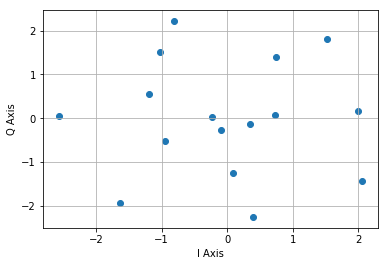

[3.1836753]
Es/No: 5 SER: 0.5104 Theor_SER_QAM: 0.5373851324942465 Theor_SER_PAM: 0.862078940761855
(6000, 16)
0 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
9 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
9 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
1 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
8 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
12 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
13 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
6 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 16)           0                                            
__________________________________________________________________________________________________
dense_5 (Dense)        

Epoch 37/50
6000/6000 [==============================] - 0s 3us/step - loss: 0.4465 - acc: 0.8453 - mean_squared_error: 0.0146
Epoch 38/50
6000/6000 [==============================] - 0s 3us/step - loss: 0.4204 - acc: 0.8478 - mean_squared_error: 0.0140
Epoch 39/50
6000/6000 [==============================] - 0s 0us/step - loss: 0.4136 - acc: 0.8497 - mean_squared_error: 0.0138
Epoch 40/50
6000/6000 [==============================] - 0s 3us/step - loss: 0.4089 - acc: 0.8592 - mean_squared_error: 0.0134
Epoch 41/50
6000/6000 [==============================] - 0s 3us/step - loss: 0.3911 - acc: 0.8617 - mean_squared_error: 0.0129
Epoch 42/50
6000/6000 [==============================] - 0s 3us/step - loss: 0.3889 - acc: 0.8618 - mean_squared_error: 0.0129
Epoch 43/50
6000/6000 [==============================] - 0s 0us/step - loss: 0.3760 - acc: 0.8645 - mean_squared_error: 0.0125
Epoch 44/50
6000/6000 [==============================] - 0s 3us/step - loss: 0.3754 - acc: 0.8642 - mean_square

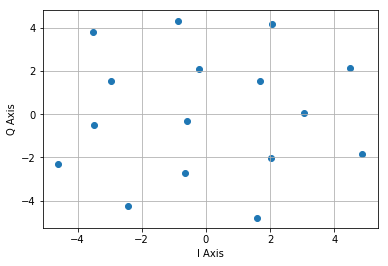

[15.887575]
Es/No: 12 SER: 0.11783333333333333 Theor_SER_QAM: 0.10935328833170666 Theor_SER_PAM: 0.7697963596067822
(10000, 16)
9 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
8 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
2 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
8 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
14 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
0 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
5 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
1 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 16)           0                                            
__________________________________________________________________________________________________
dense_9

Epoch 36/50
10000/10000 [==============================] - 0s 2us/step - loss: 0.2336 - acc: 0.9209 - mean_squared_error: 0.0075
Epoch 37/50
10000/10000 [==============================] - 0s 2us/step - loss: 0.2298 - acc: 0.9256 - mean_squared_error: 0.0073
Epoch 38/50
10000/10000 [==============================] - 0s 2us/step - loss: 0.2221 - acc: 0.9243 - mean_squared_error: 0.0072
Epoch 39/50
10000/10000 [==============================] - 0s 2us/step - loss: 0.2095 - acc: 0.9325 - mean_squared_error: 0.0067
Epoch 40/50
10000/10000 [==============================] - 0s 2us/step - loss: 0.1980 - acc: 0.9363 - mean_squared_error: 0.0063
Epoch 41/50
10000/10000 [==============================] - 0s 2us/step - loss: 0.2011 - acc: 0.9344 - mean_squared_error: 0.0064
Epoch 42/50
10000/10000 [==============================] - 0s 2us/step - loss: 0.1826 - acc: 0.9419 - mean_squared_error: 0.0058
Epoch 43/50
10000/10000 [==============================] - 0s 3us/step - loss: 0.1821 - acc: 0.94

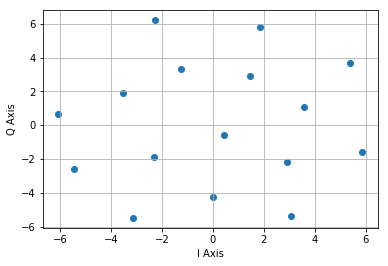

[25.364712]
Es/No: 14 SER: 0.0296 Theor_SER_QAM: 0.03715084560591553 Theor_SER_PAM: 0.7274140318971404
(18000, 16)
3 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
7 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
4 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
2 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
2 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
4 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
5 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
1 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
9 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 16)           0                                            
__________________________________________________________________________________________________
dense_13 (Dense)     

Epoch 36/50
18000/18000 [==============================] - 0s 1us/step - loss: 0.1248 - acc: 0.9660 - mean_squared_error: 0.0036
Epoch 37/50
18000/18000 [==============================] - 0s 1us/step - loss: 0.1172 - acc: 0.9676 - mean_squared_error: 0.0034
Epoch 38/50
18000/18000 [==============================] - 0s 2us/step - loss: 0.1114 - acc: 0.9689 - mean_squared_error: 0.0032
Epoch 39/50
18000/18000 [==============================] - 0s 2us/step - loss: 0.1064 - acc: 0.9687 - mean_squared_error: 0.0031
Epoch 40/50
18000/18000 [==============================] - 0s 2us/step - loss: 0.0983 - acc: 0.9718 - mean_squared_error: 0.0029
Epoch 41/50
18000/18000 [==============================] - 0s 2us/step - loss: 0.0971 - acc: 0.9716 - mean_squared_error: 0.0029
Epoch 42/50
18000/18000 [==============================] - 0s 2us/step - loss: 0.0927 - acc: 0.9723 - mean_squared_error: 0.0027
Epoch 43/50
18000/18000 [==============================] - 0s 2us/step - loss: 0.0909 - acc: 0.97

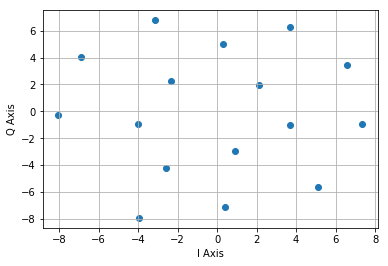

[40.217056]
Es/No: 16 SER: 0.027777777777777776 Theor_SER_QAM: 0.007152038493876245 Theor_SER_PAM: 0.6750695187632958


In [5]:
EsNodB_range = [5,12,14,16]
N_array=[5000,6000,10000,18000]
ser = [None]*len(EsNodB_range)
theor_ser_qam = [None]*len(EsNodB_range)
theor_ser_pam = [None]*len(EsNodB_range)

noise_std = np.sqrt(1)
for n in range(0,len(EsNodB_range)):
    
    EsNo=10.0**(EsNodB_range[n]/10.0)
    P = EsNo*(noise_std**2)
    
    no_errors = 0
    
    N=N_array[n]
   
    
    autoencoder = set_up_train_nn(P,EsNodB_range[n])
    
    # generating data for checking SER
    test_label = np.random.randint(M,size=N)
    test_data = []

    for i in test_label:
        temp = np.zeros(M)
        temp[i] = 1
        test_data.append(temp)

    test_data = np.array(test_data)
    
    pred_final_signal = autoencoder.predict(test_data)
    
    pred_output = np.argmax(pred_final_signal,axis=1)
    no_errors = (pred_output != test_label)
    no_errors =  no_errors.astype(int).sum()
    ser[n] = no_errors / N 
    
    erfc_arg = np.sqrt(P)/(noise_std*np.sqrt(620))
    theor_ser_pam[n] = 15*special.erfc(erfc_arg)/16
    theor_ser_qam[n] = 1.5*special.erfc(np.sqrt(EsNo/10))
    
    P_sqrtM = 0.75*special.erfc(np.sqrt(EsNo/10))
    theor_ser_qam[n] = 1-(1-P_sqrtM)**2
    
    print ('Es/No:',EsNodB_range[n],'SER:',ser[n],'Theor_SER_QAM:',theor_ser_qam[n],'Theor_SER_PAM:',theor_ser_pam[n])
    

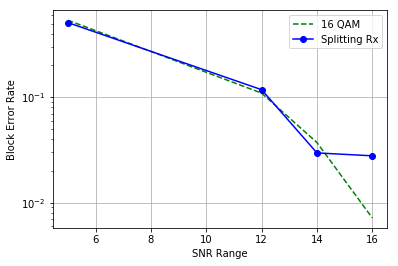

In [6]:
plt.plot(EsNodB_range, theor_ser_qam, 'g--',label='16 QAM')
#plt.plot(EsNodB_range, theor_ser_pam, 'k-',label='16 PAM')
plt.plot(EsNodB_range, ser, 'bo-',label='Splitting Rx')
plt.yscale('log')
plt.xlabel('SNR Range')
plt.ylabel('Block Error Rate')
plt.grid()
plt.legend(loc='best',ncol = 1)
plt.show()

In [7]:
ser

[0.5104, 0.11783333333333333, 0.0296, 0.027777777777777776]